In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
df = pd.read_csv("data/inverse/all_process.csv")
print(df.shape)
print(f"alert_key: {df['alert_key'].nunique()}")

df0 = df.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(df0) / df0["sar_flag"].sum()}')
print(df0["sar_flag"].value_counts())
df.head(3)

(151854, 35)
alert_key: 25751

0/1: 110.04700854700855
0.0    23672
1.0      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025
1,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.866025,-0.500000
2,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819


In [3]:
target = "sar_flag"
cat_feats = ['risk_rank', 'occupation_code', 'AGE', 'country', 'cur_type', 'debit_credit', 'tx_type', 'info_asset_code', 'fiscTxId', 'txbranch', 'cross_bank', 'ATM', 'trans_no']
num_feats = ['total_asset', 'lupay', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah', 'amt', 'tx_amt', 'trade_amount_usd']
cycle_feats = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']
othet_feats = ['alert_key', 'date', 'cust_id']

In [4]:
train = df[~df["sar_flag"].isnull()].copy()
test = df[df["sar_flag"].isnull()].copy()
print(f"train: {len(train)}, test: {len(test)}")

train: 136385, test: 15469


In [5]:
public = pd.read_csv("data/submit/1217_1.csv")
public = public.set_index("alert_key")["probability"].to_dict()

In [6]:
test["sar_flag"] = test["alert_key"].apply(lambda X: public[X])

In [7]:
train[target] = train[target].astype(int)
test[target] = test[target].astype(int)

In [8]:
train1 = train.copy()

## 刪除沒有交易資料的樣本

In [9]:
null_trade_data = train1[(train1.loc[:, "country":"trade_amount_usd"] == 0).all(axis = 1)]
null_trade_data["sar_flag"].value_counts()

0    32922
Name: sar_flag, dtype: int64

In [10]:
train1 = (
    train1
    .drop(null_trade_data.index)
    .reset_index(drop = True)
    )

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

train shape: (103463, 35)
alert_key: 16635

0/1: 71.08974358974359
0    16401
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025
1,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819
2,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819


## 刪除變數數值超過變數在sar_flag = 1的最大/小值之樣本

In [11]:
des1 = train1[train1[target] == 1][num_feats].describe()
des1

,total_asset,lupay,cycam,usgam,clamt,csamt,inamt,cucsm,cucah,amt,tx_amt,trade_amount_usd
count,2.687000e+03,2.687000e+03,2.687000e+03,2.687000e+03,2687.0,2687.0,2687.000000,2.687000e+03,2687.0,2.687000e+03,2.687000e+03,2687.000000
mean,5.699954e+05,1.058319e+06,1.122453e+05,4.001076e+04,0.0,0.0,1835.493115,1.041380e+06,0.0,2.004396e+03,1.195692e+06,2579.779680
std,1.596499e+06,3.700122e+06,1.519197e+05,1.973354e+05,0.0,0.0,8956.836319,3.682462e+06,0.0,5.352895e+04,2.165223e+07,24269.482852
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.910575e+06,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000
25%,5.658000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,5.345000e+02,0.000000
50%,1.388970e+05,1.540000e+02,5.125300e+04,3.082000e+03,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000e+00,1.029700e+04,0.000000
75%,5.134620e+05,2.073700e+04,1.672350e+05,5.926800e+04,0.0,0.0,0.000000,2.925800e+04,0.0,0.000000e+00,8.703634e+04,0.000000
max,1.442488e+07,2.748978e+07,1.037944e+06,5.205880e+05,0.0,0.0,188706.000000,3.581776e+07,0.0,2.464629e+06,7.841298e+08,893881.000000


In [12]:
des1 = des1.loc[["min", "max"]]
des1 = des1.to_dict()
des1

{'total_asset': {'min': 0.0, 'max': 14424881.0},
 'lupay': {'min': 0.0, 'max': 27489779.0},
 'cycam': {'min': 0.0, 'max': 1037944.0},
 'usgam': {'min': -2910575.0, 'max': 520588.0},
 'clamt': {'min': 0.0, 'max': 0.0},
 'csamt': {'min': 0.0, 'max': 0.0},
 'inamt': {'min': 0.0, 'max': 188706.0},
 'cucsm': {'min': 0.0, 'max': 35817760.0},
 'cucah': {'min': 0.0, 'max': 0.0},
 'amt': {'min': 0.0, 'max': 2464629.0},
 'tx_amt': {'min': 0.0, 'max': 784129777.1999999},
 'trade_amount_usd': {'min': 0.0, 'max': 893881.0}}

In [13]:
print(f"init: {len(train1)}")
for feat in num_feats:
    train1 = train1[(train1[feat] >= des1[feat]["min"]) & (train1[feat] <=  des1[feat]["max"])]
    print(f"{feat}: {len(train1)}")

init: 103463
total_asset: 103339
lupay: 103307
cycam: 102687
usgam: 101613
clamt: 101057
csamt: 101053
inamt: 101002
cucsm: 100535
cucah: 100494
amt: 100479
tx_amt: 100477
trade_amount_usd: 100472


In [14]:
df["alert_key"].nunique(), train1["alert_key"].nunique(), df["alert_key"].nunique() - train1["alert_key"].nunique()

(25751, 15891, 9860)

In [15]:
train1 = train1.reset_index(drop = True)

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

train shape: (100472, 35)
alert_key: 15891

0/1: 67.91025641025641
0    15657
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025
1,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819
2,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819


## 刪除ccba中變數比值超過變數比值在sar_flag = 1的最大/小值之樣本

In [16]:
train1["lupay1"] = train1["usgam"]/(train1["lupay"]+1e-7)
train1["usgam1"] = train1["usgam"]/(train1["cycam"]+1e-7)
train1["clamt1"] = train1["clamt"]/(train1["cycam"]+1e-7)
train1["csamt1"] = train1["csamt"]/(train1["cycam"]+1e-7)
train1["inamt1"] = train1["inamt"]/(train1["cycam"]+1e-7)
train1["cucsm1"] = train1["cucsm"]/(train1["cycam"]+1e-7)
train1["cucah1"] = train1["cucah"]/(train1["cycam"]+1e-7)
train1.head(3)

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,day_cos,hour_sin,hour_cos,lupay1,usgam1,clamt1,csamt1,inamt1,cucsm1,cucah1
0,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,0.97953,-0.500000,-0.866025,6.585595,0.548931,0.0,0.0,0.082769,0.082769,0.0
1,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,0.97953,-0.965926,-0.258819,6.585595,0.548931,0.0,0.0,0.082769,0.082769,0.0
2,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,0.97953,-0.965926,-0.258819,6.585595,0.548931,0.0,0.0,0.082769,0.082769,0.0


In [17]:
prob_feat = train1.columns[-7:].tolist()
des1 = train1[train1[target] == 1][["alert_key"] + prob_feat].drop_duplicates()
des1 = des1.describe()
des1 = des1.loc[["min", "max"]]
des1 = des1.to_dict()
des1

{'alert_key': {'min': 171770.0, 'max': 351367.0},
 'lupay1': {'min': -4140000000.0, 'max': 706760000000.0},
 'usgam1': {'min': -12.765455869189678, 'max': 1.2428568700100169},
 'clamt1': {'min': 0.0, 'max': 0.0},
 'csamt1': {'min': 0.0, 'max': 0.0},
 'inamt1': {'min': 0.0, 'max': 2.014239053858619},
 'cucsm1': {'min': 0.0, 'max': 134.71034414512556},
 'cucah1': {'min': 0.0, 'max': 0.0}}

In [18]:
print(f"init: {len(train1)}")
for feat in prob_feat:
    train1 = train1[(train1[feat] >= des1[feat]["min"]) & (train1[feat] <=  des1[feat]["max"])]
    print(f"{feat}: {len(train1)}")

init: 100472
lupay1: 99922
usgam1: 99238
clamt1: 99238
csamt1: 99238
inamt1: 99238
cucsm1: 99238
cucah1: 99238


In [19]:
train1 = train1.reset_index(drop = True)
train1 = train1.drop(prob_feat, axis = 1)

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

train shape: (99238, 35)
alert_key: 15608

0/1: 66.7008547008547
0    15374
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025
1,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819
2,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819


## 刪除部分risk_rank = 3 之樣本

In [20]:
# 各類別在sar為1或0的個數
df_gbs = pd.DataFrame()
for feat in cat_feats:
    df_gb = train1.groupby([feat, target]).size().unstack().dropna()
    df_gb = df_gb.reset_index()
    df_gb.insert(0, "feature", df_gb.columns[0])
    df_gb.columns = ["feat", "type", "count0", "count1"]
    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs["prob"] = df_gbs.eval("count1/(count0 + count1)")
df_gbs = df_gbs.sort_values("prob", ascending = False)
df_gbs.head(3)

,feat,type,count0,count1,prob
31,country,28,3.0,5.0,0.625000
127,txbranch,122,16.0,11.0,0.407407
27,AGE,8,38.0,14.0,0.269231


In [21]:
df_gbs1 = df_gbs.query("feat == 'risk_rank'")
df_gbs1

,feat,type,count0,count1,prob
0,risk_rank,1,32861.0,2329.0,0.066184
1,risk_rank,2,1131.0,64.0,0.053556
2,risk_rank,3,62542.0,294.0,0.004679


In [22]:
# count1 / ((count0 - remove_count) + count1) = expect_prob
# count1 / expect_prob = count0 - remove_count + count1
# remove_count = (count0 + count1) - (count1 / expect_prob)

count0 = df_gbs1.query("type == 3").iloc[0, 2]
count1 = df_gbs1.query("type == 3").iloc[0, 3]
expect_prob = df_gbs1.query("type == 1").iloc[0, 4]
print(count0, count1, expect_prob)

remove_count = count0 + count1 - (count1 / expect_prob)
remove_count = int(remove_count)
remove_count

62542.0 294.0 0.06618357487922705


58393

In [23]:
train1_remove = train1.query("(risk_rank == 3) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
train1 = (
    train1
    .drop(train1_remove.index)
    .reset_index(drop = True)
    )

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

train shape: (40845, 35)
alert_key: 11943

0/1: 51.03846153846154
0    11709
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,0.965926
1,171177,2021-04-01,0,5052,1,19,51160.0,4,0.0,0.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,-0.965926
2,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025


## 刪除部分occupation_code = 19 之樣本

In [24]:
# 各類別在sar為1或0的個數
df_gbs = pd.DataFrame()
for feat in cat_feats:
    df_gb = train1.groupby([feat, target]).size().unstack().dropna()
    df_gb = df_gb.reset_index()
    df_gb.insert(0, "feature", df_gb.columns[0])
    df_gb.columns = ["feat", "type", "count0", "count1"]
    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs["prob"] = df_gbs.eval("count1/(count0 + count1)")
df_gbs = df_gbs.sort_values("prob", ascending = False)
df_gbs.head(3)

,feat,type,count0,count1,prob
31,country,28,3.0,5.0,0.625000
3,occupation_code,1,94.0,122.0,0.564815
46,cur_type,14,1.0,1.0,0.500000


In [25]:
df_gbs1 = df_gbs.query("feat == 'occupation_code'").reset_index(drop = True)
df_gbs1

,feat,type,count0,count1,prob
0,occupation_code,1,94.0,122.0,0.564815
1,occupation_code,8,11.0,3.0,0.214286
2,occupation_code,16,134.0,27.0,0.167702
3,occupation_code,15,1220.0,200.0,0.140845
4,occupation_code,11,476.0,74.0,0.134545
5,occupation_code,13,1639.0,179.0,0.098460
6,occupation_code,17,4379.0,414.0,0.086376
7,occupation_code,18,3101.0,284.0,0.083900
8,occupation_code,14,1102.0,81.0,0.068470
9,occupation_code,2,200.0,14.0,0.065421


In [26]:
count0 = df_gbs1.query("type == 19").iloc[0, 2]
count1 = df_gbs1.query("type == 19").iloc[0, 3]
expect_prob = df_gbs1.query("type == 12").iloc[0, 4]
print(count0, count1, expect_prob)

remove_count = count0 + count1 - (count1 / expect_prob)
remove_count = int(remove_count)
remove_count

10072.0 454.0 0.05361371601780809


2058

In [27]:
train1_remove = train1.query("(occupation_code == 19) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
train1 = (
    train1
    .drop(train1_remove.index)
    .reset_index(drop = True)
    )
    
print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

train shape: (38787, 35)
alert_key: 11704

0/1: 50.01709401709402
0    11470
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,0.965926
1,171177,2021-04-01,0,5052,1,19,51160.0,4,0.0,0.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,-0.965926
2,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025


## 刪除部分debit_credit = 1 之樣本

In [28]:
# 各類別在sar為1或0的個數
df_gbs = pd.DataFrame()
for feat in cat_feats:
    df_gb = train1.groupby([feat, target]).size().unstack().dropna()
    df_gb = df_gb.reset_index()
    df_gb.insert(0, "feature", df_gb.columns[0])
    df_gb.columns = ["feat", "type", "count0", "count1"]
    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs["prob"] = df_gbs.eval("count1/(count0 + count1)")
df_gbs = df_gbs.sort_values("prob", ascending = False)
df_gbs.head(3)

,feat,type,count0,count1,prob
31,country,28,3.0,5.0,0.625000
3,occupation_code,1,94.0,122.0,0.564815
133,txbranch,135,2.0,2.0,0.500000


In [29]:
df_gbs1 = df_gbs.query("feat == 'debit_credit'").reset_index(drop = True)
df_gbs1

,feat,type,count0,count1,prob
0,debit_credit,1,6324.0,814.0,0.114038
1,debit_credit,-1,13197.0,1654.0,0.111373
2,debit_credit,0,16579.0,219.0,0.013037


In [30]:
count0 = df_gbs1.query("type == -1").iloc[0, 2]
count1 = df_gbs1.query("type == -1").iloc[0, 3] 
expect_prob = df_gbs1.query("type == 1").iloc[0, 4]
print(count0, count1, expect_prob)

remove_count = count0 + count1 - (count1 / expect_prob)
remove_count = int(remove_count)
remove_count

13197.0 1654.0 0.11403754553096106


347

In [31]:
train1_remove = train1.query("(debit_credit == -1) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
train1 = (
    train1
    .drop(train1_remove.index)
    .reset_index(drop = True)
    )
    
print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

train shape: (38440, 35)
alert_key: 11670

0/1: 49.87179487179487
0    11436
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,0.965926
1,171177,2021-04-01,0,5052,1,19,51160.0,4,0.0,0.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,-0.965926
2,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025


## 刪除部分cross_bank = 2 之樣本

In [32]:
# 各類別在sar為1或0的個數
df_gbs = pd.DataFrame()
for feat in cat_feats:
    df_gb = train1.groupby([feat, target]).size().unstack().dropna()
    df_gb = df_gb.reset_index()
    df_gb.insert(0, "feature", df_gb.columns[0])
    df_gb.columns = ["feat", "type", "count0", "count1"]
    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs["prob"] = df_gbs.eval("count1/(count0 + count1)")
df_gbs = df_gbs.sort_values("prob", ascending = False)
df_gbs.head(3)

,feat,type,count0,count1,prob
31,country,28,3.0,5.0,0.625000
3,occupation_code,1,93.0,122.0,0.567442
133,txbranch,135,2.0,2.0,0.500000


In [33]:
df_gbs1 = df_gbs.query("feat == 'cross_bank'").reset_index(drop = True)
df_gbs1

,feat,type,count0,count1,prob
0,cross_bank,1,8306.0,1410.0,0.145121
1,cross_bank,2,10868.0,1058.0,0.088714
2,cross_bank,0,16579.0,219.0,0.013037


In [34]:
count0 = df_gbs1.query("type == 2").iloc[0, 2]
count1 = df_gbs1.query("type == 2").iloc[0, 3]
expect_prob = df_gbs1.query("type == 1").iloc[0, 4]
print(count0, count1, expect_prob)

remove_count = count0 + count1 - (count1 / expect_prob)
remove_count = int(remove_count)
remove_count

10868.0 1058.0 0.14512144915603128


4635

In [35]:
train1_remove = train1.query("(cross_bank == 2) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
train1 = (
    train1
    .drop(train1_remove.index)
    .reset_index(drop = True)
    )
    
print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

train shape: (33805, 35)
alert_key: 11262

0/1: 48.12820512820513
0    11028
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171177,2021-04-01,0,5052,1,19,51160.0,4,0.0,0.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,-0.965926
1,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025
2,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.000000,0.000000


## 刪除部分AGE、ATM之樣本

In [36]:
# 類別變數配對組合
pair_cat_feats = []
for i in range(3):
    for j in range(len(cat_feats)):
        if (cat_feats[i] != cat_feats[j]) & (cat_feats[j] != "txbranch"):
            pair = set([cat_feats[i], cat_feats[j]])
            if pair not in pair_cat_feats:
                pair_cat_feats.append(pair)

pair_cat_feats.append(set(['country', 'cur_type']))

for i in range(5, 12):
    for j in range(5, 12):
        if (cat_feats[i] != cat_feats[j]) & (cat_feats[j] != "txbranch") & (cat_feats[i] != "txbranch"):
            pair = set([cat_feats[i], cat_feats[j]])
            if pair not in pair_cat_feats:
                pair_cat_feats.append(pair)


pair_cat_feats = [sorted(i) for i in pair_cat_feats]
pair_cat_feats = sorted(pair_cat_feats, key = lambda X: [list(X)[0], list(X)[1]])

len(pair_cat_feats)

46

In [37]:
df_gbs = pd.DataFrame()
feats = pair_cat_feats
for feat1, feat2 in pair_cat_feats:
    train2 = train1[(train1[feat1] != 0) & (train1[feat2] != 0)]

    df_gb = train2.groupby([feat1, feat2, target]).size().unstack()
    df_gb = df_gb.dropna()

    df_gb = df_gb.reset_index()
    col = df_gb.columns
    df_gb.insert(0, "cat1", col[0])
    df_gb.insert(2, "cat2", col[1])
    df_gb.columns = ["cat1", "cat_type1", "cat2", "cat_type2", "count0", "count1"]
    
    df_gb["prop"] = df_gb["count1"] / (df_gb["count0"] + df_gb["count1"])
    df_gb["prop1"] = df_gb["count1"]/df_gb["count1"].sum()

    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs = df_gbs.sort_values("prop", ascending = False)

In [38]:
df_gbs1 = df_gbs.query("(cat1 == 'AGE') & (cat2 == 'ATM')")
df_gbs1

,cat1,cat_type1,cat2,cat_type2,count0,count1,prop,prop1
7,AGE,8,ATM,2,22.0,13.0,0.371429,0.005664
0,AGE,1,ATM,2,26.0,9.0,0.257143,0.003922
2,AGE,3,ATM,2,5368.0,1243.0,0.188020,0.541612
1,AGE,2,ATM,2,3259.0,467.0,0.125335,0.203486
5,AGE,6,ATM,2,452.0,62.0,0.120623,0.027015
6,AGE,7,ATM,2,75.0,9.0,0.107143,0.003922
3,AGE,4,ATM,2,3665.0,364.0,0.090345,0.158606
4,AGE,5,ATM,2,1665.0,128.0,0.071389,0.055773


In [39]:
remmove_type = [[2, 2], [4, 2], [5, 2], [6, 2]]
for type1, type2 in remmove_type:
    print(f"AGE = {type1}, ATM = {type2}")
    count0 = df_gbs1.query("(cat_type1 == @type1) & (cat_type2 == @type2)").iloc[0, 4]
    count1 = df_gbs1.query("(cat_type1 == @type1) & (cat_type2 == @type2)").iloc[0, 5]
    expect_prob = df_gbs1.query("(cat_type1 == 3) & (cat_type2 == 2)").iloc[0, 6]
    print(f"count0 = {count0}, count1 = {count1}, expect_prob = {expect_prob}")

    remove_count = count0 + count1 - (count1 / expect_prob)
    remove_count = int(remove_count)
    print(f"remove: {remove_count}\n")

    train1_remove = train1.query("(AGE == @type1) & (ATM == @type2) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
    train1 = (
        train1
        .drop(train1_remove.index)
        .reset_index(drop = True)
        )

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

AGE = 2, ATM = 2
count0 = 3259.0, count1 = 467.0, expect_prob = 0.18801996672212978
remove: 1242

AGE = 4, ATM = 2
count0 = 3665.0, count1 = 364.0, expect_prob = 0.18801996672212978
remove: 2093

AGE = 5, ATM = 2
count0 = 1665.0, count1 = 128.0, expect_prob = 0.18801996672212978
remove: 1112

AGE = 6, ATM = 2
count0 = 452.0, count1 = 62.0, expect_prob = 0.18801996672212978
remove: 184

train shape: (29174, 35)
alert_key: 10497

0/1: 44.85897435897436
0    10263
1      234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171177,2021-04-01,0,5052,1,19,51160.0,4,0.0,0.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.258819,-0.965926
1,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.000000,0.000000
2,171189,2021-04-01,0,4549,1,17,375576.0,4,85428.0,301224.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.000000,0.000000


## 刪除部分cross_bank、info_asset_code之樣本

In [40]:
df_gbs = pd.DataFrame()
feats = pair_cat_feats
for feat1, feat2 in pair_cat_feats:
    train2 = train1[(train1[feat1] != 0) & (train1[feat2] != 0)]

    df_gb = train2.groupby([feat1, feat2, target]).size().unstack()
    df_gb = df_gb.dropna()

    df_gb = df_gb.reset_index()
    col = df_gb.columns
    df_gb.insert(0, "cat1", col[0])
    df_gb.insert(2, "cat2", col[1])
    df_gb.columns = ["cat1", "cat_type1", "cat2", "cat_type2", "count0", "count1"]
    
    df_gb["prop"] = df_gb["count1"] / (df_gb["count0"] + df_gb["count1"])
    df_gb["prop1"] = df_gb["count1"]/df_gb["count1"].sum()

    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs = df_gbs.sort_values("prop", ascending = False)

In [41]:
df_gbs1 = df_gbs.query("(cat1 == 'cross_bank') & (cat2 == 'info_asset_code')")
df_gbs1

,cat1,cat_type1,cat2,cat_type2,count0,count1,prop,prop1
314,cross_bank,2,info_asset_code,11,4596.0,1058.0,0.187124,0.652684
313,cross_bank,1,info_asset_code,11,5312.0,563.0,0.095830,0.347316


In [42]:
remmove_type = [[1, 11]]
expect = [2, 11]
for type1, type2 in remmove_type:
    print(f"cross_bank = {type1}, info_asset_code = {type2}")
    count0 = df_gbs1.query("(cat_type1 == @type1) & (cat_type2 == @type2)").iloc[0, 4]
    count1 = df_gbs1.query("(cat_type1 ==  @type1) & (cat_type2 == @type2)").iloc[0, 5]
    expect_prob = df_gbs1.query("(cat_type1 == @expect[0]) & (cat_type2 == @expect[1])").iloc[0, 6]
    print(f"count0 = {count0}, count1 = {count1}, expect_prob = {expect_prob}")

    remove_count = count0 + count1 - (count1 / expect_prob)
    remove_count = int(remove_count)
    print(f"remove: {remove_count}\n")

    train1_remove = train1.query("(cross_bank == @type1) & (info_asset_code == @type2) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
    train1 = (
        train1
        .drop(train1_remove.index)
        .reset_index(drop = True)
        )

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

cross_bank = 1, info_asset_code = 11
count0 = 5312.0, count1 = 563.0, expect_prob = 0.1871241598868058
remove: 2866

train shape: (26308, 35)
alert_key: 9852

0/1: 42.1025641025641
0    9618
1     234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.0,0.000000
1,171189,2021-04-01,0,4549,1,17,375576.0,4,85428.0,301224.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.0,0.000000
2,171207,2021-04-01,0,2027,1,19,358135.0,3,0.0,175543.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.5,-0.866025


## 刪除部分ATM、cross_bank之樣本

In [43]:
df_gbs = pd.DataFrame()
feats = pair_cat_feats
for feat1, feat2 in pair_cat_feats:
    train2 = train1[(train1[feat1] != 0) & (train1[feat2] != 0)]

    df_gb = train2.groupby([feat1, feat2, target]).size().unstack()
    df_gb = df_gb.dropna()

    df_gb = df_gb.reset_index()
    col = df_gb.columns
    df_gb.insert(0, "cat1", col[0])
    df_gb.insert(2, "cat2", col[1])
    df_gb.columns = ["cat1", "cat_type1", "cat2", "cat_type2", "count0", "count1"]
    
    df_gb["prop"] = df_gb["count1"] / (df_gb["count0"] + df_gb["count1"])
    df_gb["prop1"] = df_gb["count1"]/df_gb["count1"].sum()

    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs = df_gbs.sort_values("prop", ascending = False)

In [44]:
df_gbs1 = df_gbs.query("(cat1 == 'ATM') & (cat2 == 'cross_bank')")
df_gbs1

,cat1,cat_type1,cat2,cat_type2,count0,count1,prop,prop1
204,ATM,2,cross_bank,1,2446.0,1237.0,0.335867,0.538998
205,ATM,2,cross_bank,2,4596.0,1058.0,0.187124,0.461002


In [45]:
remmove_type = [[2, 2]]
expect = [2, 1]
for type1, type2 in remmove_type:
    print(f"cross_bank = {type1}, fiscTxId = {type2}")
    count0 = df_gbs1.query("(cat_type1 == @type1) & (cat_type2 == @type2)").iloc[0, 4]
    count1 = df_gbs1.query("(cat_type1 ==  @type1) & (cat_type2 == @type2)").iloc[0, 5]
    expect_prob = df_gbs1.query("(cat_type1 == @expect[0]) & (cat_type2 == @expect[1])").iloc[0, 6]
    print(f"count0 = {count0}, count1 = {count1}, expect_prob = {expect_prob}")

    remove_count = count0 + count1 - (count1 / expect_prob)
    remove_count = int(remove_count)
    print(f"remove: {remove_count}\n")

    train1_remove = train1.query("(ATM == @type1) & (cross_bank == @type2) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
    train1 = (
        train1
        .drop(train1_remove.index)
        .reset_index(drop = True)
        )

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

cross_bank = 2, fiscTxId = 2
count0 = 4596.0, count1 = 1058.0, expect_prob = 0.3358674993212055
remove: 2503

train shape: (23805, 35)
alert_key: 9527

0/1: 40.71367521367522
0    9293
1     234
Name: sar_flag, dtype: int64


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.0,0.000000
1,171189,2021-04-01,0,4549,1,17,375576.0,4,85428.0,301224.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.0,0.000000
2,171207,2021-04-01,0,2027,1,19,358135.0,3,0.0,175543.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.5,-0.866025


## 刪除部分occupation_code、trans_no之樣本

In [46]:
df_gbs = pd.DataFrame()
feats = pair_cat_feats
for feat1, feat2 in pair_cat_feats:
    train2 = train1[(train1[feat1] != 0) & (train1[feat2] != 0)]

    df_gb = train2.groupby([feat1, feat2, target]).size().unstack()
    df_gb = df_gb.dropna()

    df_gb = df_gb.reset_index()
    col = df_gb.columns
    df_gb.insert(0, "cat1", col[0])
    df_gb.insert(2, "cat2", col[1])
    df_gb.columns = ["cat1", "cat_type1", "cat2", "cat_type2", "count0", "count1"]
    
    df_gb["prop"] = df_gb["count1"] / (df_gb["count0"] + df_gb["count1"])
    df_gb["prop1"] = df_gb["count1"]/df_gb["count1"].sum()

    df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

df_gbs = df_gbs.sort_values("prop", ascending = False)

In [47]:
df_gbs1 = df_gbs.query("(cat1 == 'occupation_code') & (cat2 == 'trans_no')")
df_gbs1

,cat1,cat_type1,cat2,cat_type2,count0,count1,prop,prop1
598,occupation_code,12,trans_no,3,1.0,1.0,0.500000,0.012195
590,occupation_code,1,trans_no,1,37.0,11.0,0.229167,0.134146
592,occupation_code,3,trans_no,1,34.0,3.0,0.081081,0.036585
605,occupation_code,19,trans_no,1,352.0,21.0,0.056300,0.256098
602,occupation_code,15,trans_no,1,205.0,9.0,0.042056,0.109756
596,occupation_code,9,trans_no,4,24.0,1.0,0.040000,0.012195
600,occupation_code,13,trans_no,1,100.0,4.0,0.038462,0.048780
599,occupation_code,12,trans_no,4,29.0,1.0,0.033333,0.012195
606,occupation_code,19,trans_no,2,61.0,2.0,0.031746,0.024390
601,occupation_code,14,trans_no,1,32.0,1.0,0.030303,0.012195


In [48]:
remmove_type = [[12, 1], [17, 1], [18, 1], [15, 1], [2, 1], [4, 1], [5, 1], [9, 1], [9, 4]]
expect = [19, 1]
for type1, type2 in remmove_type:
    print(f"occupation_code = {type1}, trans_no = {type2}")
    count0 = df_gbs1.query("(cat_type1 == @type1) & (cat_type2 == @type2)").iloc[0, 4]
    count1 = df_gbs1.query("(cat_type1 ==  @type1) & (cat_type2 == @type2)").iloc[0, 5]
    expect_prob = df_gbs1.query("(cat_type1 == @expect[0]) & (cat_type2 == @expect[1])").iloc[0, 6]
    print(f"count0 = {count0}, count1 = {count1}, expect_prob = {expect_prob}")

    remove_count = count0 + count1 - (count1 / expect_prob)
    remove_count = int(remove_count)
    print(f"remove: {remove_count}\n")

    train1_remove = train1.query("(occupation_code == @type1) & (trans_no == @type2) & (sar_flag == 0)").sample(n = remove_count, random_state = 99)
    train1 = (
        train1
        .drop(train1_remove.index)
        .reset_index(drop = True)
        )

print(f"train shape: {train1.shape}")
print(f"alert_key: {train1['alert_key'].nunique()}")

train1_0 = train1.iloc[:, :3].drop_duplicates()
print(f'\n0/1: {len(train1_0) / train1_0[target].sum()}')
print(train1_0[target].value_counts())
train1.head(3)

occupation_code = 12, trans_no = 1
count0 = 417.0, count1 = 5.0, expect_prob = 0.05630026809651475
remove: 333

occupation_code = 17, trans_no = 1
count0 = 449.0, count1 = 13.0, expect_prob = 0.05630026809651475
remove: 231

occupation_code = 18, trans_no = 1
count0 = 315.0, count1 = 5.0, expect_prob = 0.05630026809651475
remove: 231

occupation_code = 15, trans_no = 1
count0 = 205.0, count1 = 9.0, expect_prob = 0.05630026809651475
remove: 54

occupation_code = 2, trans_no = 1
count0 = 127.0, count1 = 1.0, expect_prob = 0.05630026809651475
remove: 110

occupation_code = 4, trans_no = 1
count0 = 53.0, count1 = 1.0, expect_prob = 0.05630026809651475
remove: 36

occupation_code = 5, trans_no = 1
count0 = 55.0, count1 = 1.0, expect_prob = 0.05630026809651475
remove: 38

occupation_code = 9, trans_no = 1
count0 = 88.0, count1 = 2.0, expect_prob = 0.05630026809651475
remove: 54

occupation_code = 9, trans_no = 4
count0 = 24.0, count1 = 1.0, expect_prob = 0.05630026809651475
remove: 7

train 

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171180,2021-04-01,0,3080,1,17,4076287.0,4,636.0,256134.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.0,0.000000
1,171189,2021-04-01,0,4549,1,17,375576.0,4,85428.0,301224.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,0.0,0.000000
2,171207,2021-04-01,0,2027,1,19,358135.0,3,0.0,175543.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.5,-0.866025


In [49]:
df1 = pd.concat([train1, test], ignore_index = False)
df1.to_csv("data/inverse/all_imbalance.csv")

In [50]:
test1 = test.copy()
test1["sar_flag"] = test1["sar_flag"].replace(0, 2).replace(1, 3)
train1 = pd.concat([train1, test1], ignore_index = False)
train1.tail()

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
151849,365073,2022-04-29,2,3382,3,19,83133.0,3,0.0,0.0,...,2,2,0,0.0,0.866025,-0.5,-0.394356,0.918958,-0.258819,0.965926
151850,365073,2022-04-29,2,3382,3,19,83133.0,3,0.0,0.0,...,2,2,0,0.0,0.866025,-0.5,-0.394356,0.918958,-0.258819,0.965926
151851,365073,2022-04-29,2,3382,3,19,83133.0,3,0.0,0.0,...,2,2,0,0.0,0.866025,-0.5,-0.394356,0.918958,-0.258819,0.965926
151852,365073,2022-04-29,2,3382,3,19,83133.0,3,0.0,0.0,...,1,2,0,0.0,0.866025,-0.5,-0.394356,0.918958,-0.258819,0.965926
151853,365073,2022-04-29,2,3382,3,19,83133.0,3,0.0,0.0,...,1,2,0,0.0,0.866025,-0.5,-0.394356,0.918958,-0.258819,0.965926


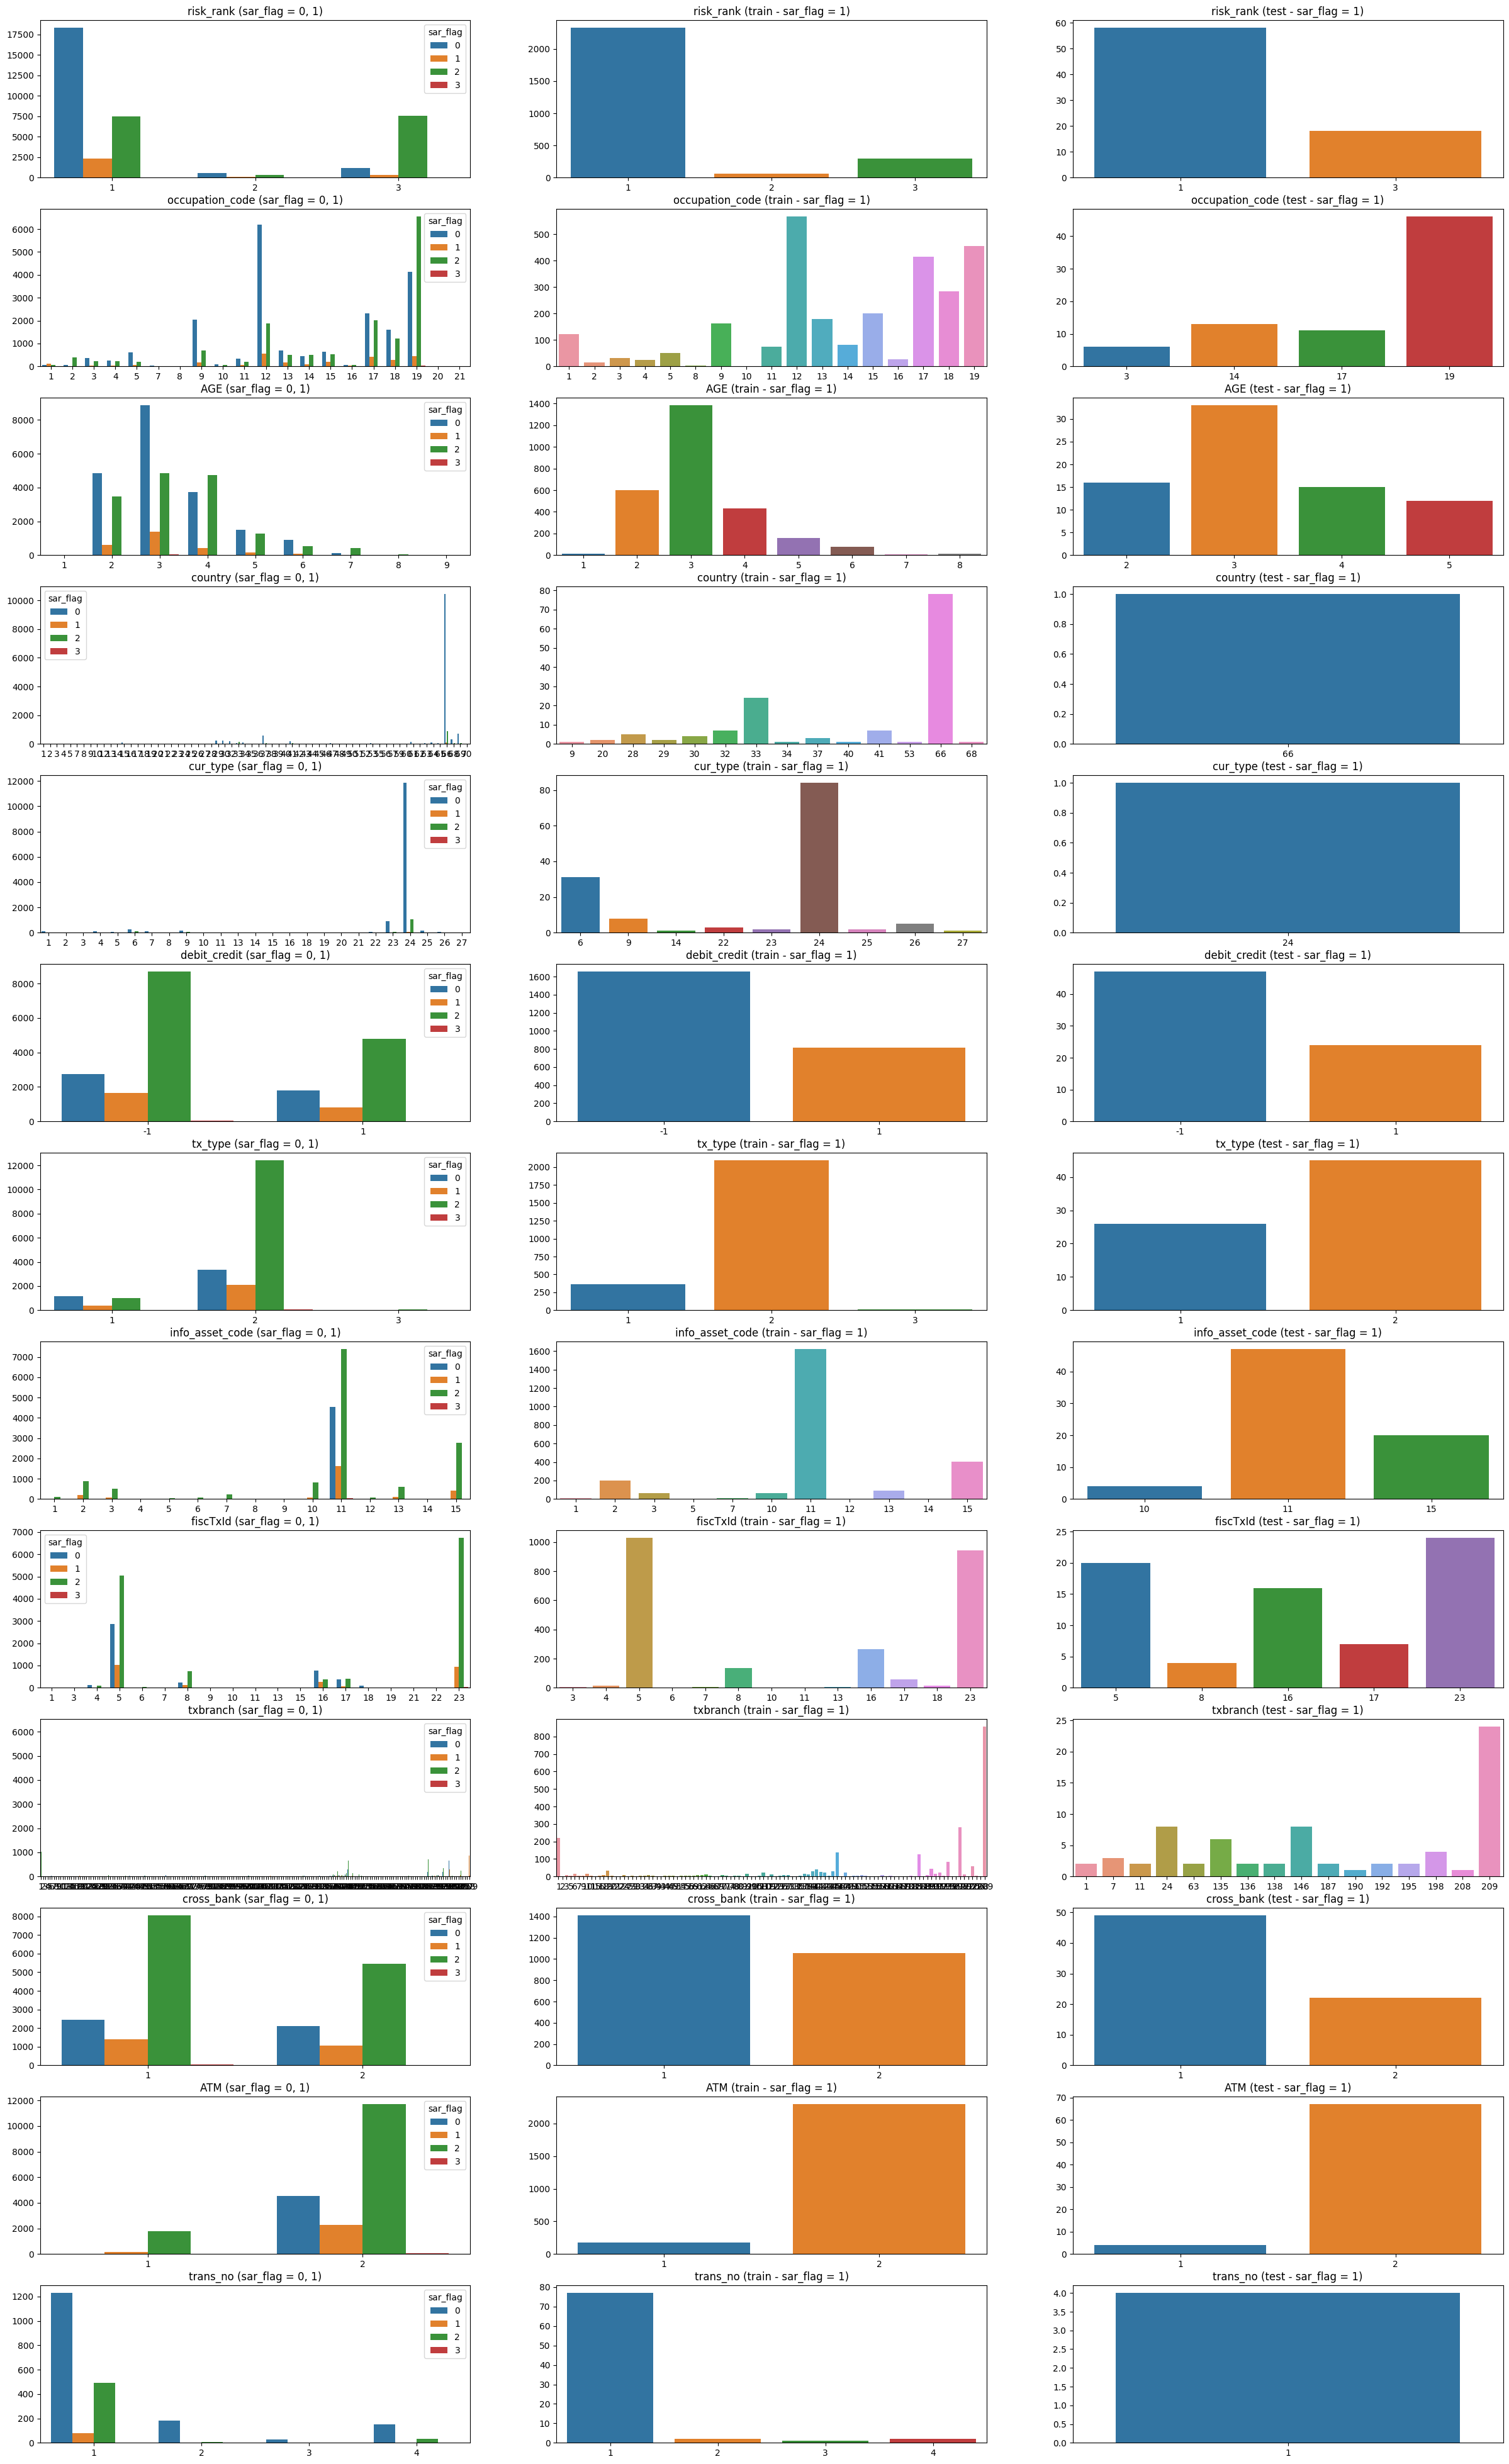

In [51]:
# 各類別變數與y的關係
## 沒出現在sar_falg = 1的類別，以-1取代
feats = cat_feats
k = 0
a, b = 13, 3
fig, ax = plt.subplots(a, b, figsize = (30, 50))
for i in range(a):
    for j in range(1):
        try:
            if feats[k] != "debit_credit":
                data = train1[(train1[feats[k]] > 0)]
            else:
                data = train1[(train1[feats[k]] != 0)]

            sns.countplot(data = data, x = feats[k], hue = target, ax = ax[i, j])
            sns.countplot(data = data.query("(sar_flag == 1)"), x = feats[k], ax = ax[i, j+1])
            sns.countplot(data = data.query("(sar_flag == 3)"), x = feats[k], ax = ax[i, j+2])

            ax[i, j].set(ylabel = None, xlabel = None, title = f"{feats[k]} (sar_flag = 0, 1)")
            ax[i, j + 1].set(ylabel = None, xlabel = None, title = f"{feats[k]} (train - sar_flag = 1)")
            ax[i, j + 2].set(ylabel = None, xlabel = None, title = f"{feats[k]} (test - sar_flag = 1)")
            k += 1
        except:
            continue

# fig.savefig("data/image/cat_feats_replace.png")

In [52]:
# 沒出現在sar_falg = 1的類別，以-1取代
train2 = train1.copy()
for feat in tqdm(cat_feats):
    train3 = train2[[target] + [feat]]
    cat = train3[train3[target] == 1][feat].unique()
    train2[feat] = train2[feat].apply(lambda X: -1 if X not in cat else X)

100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


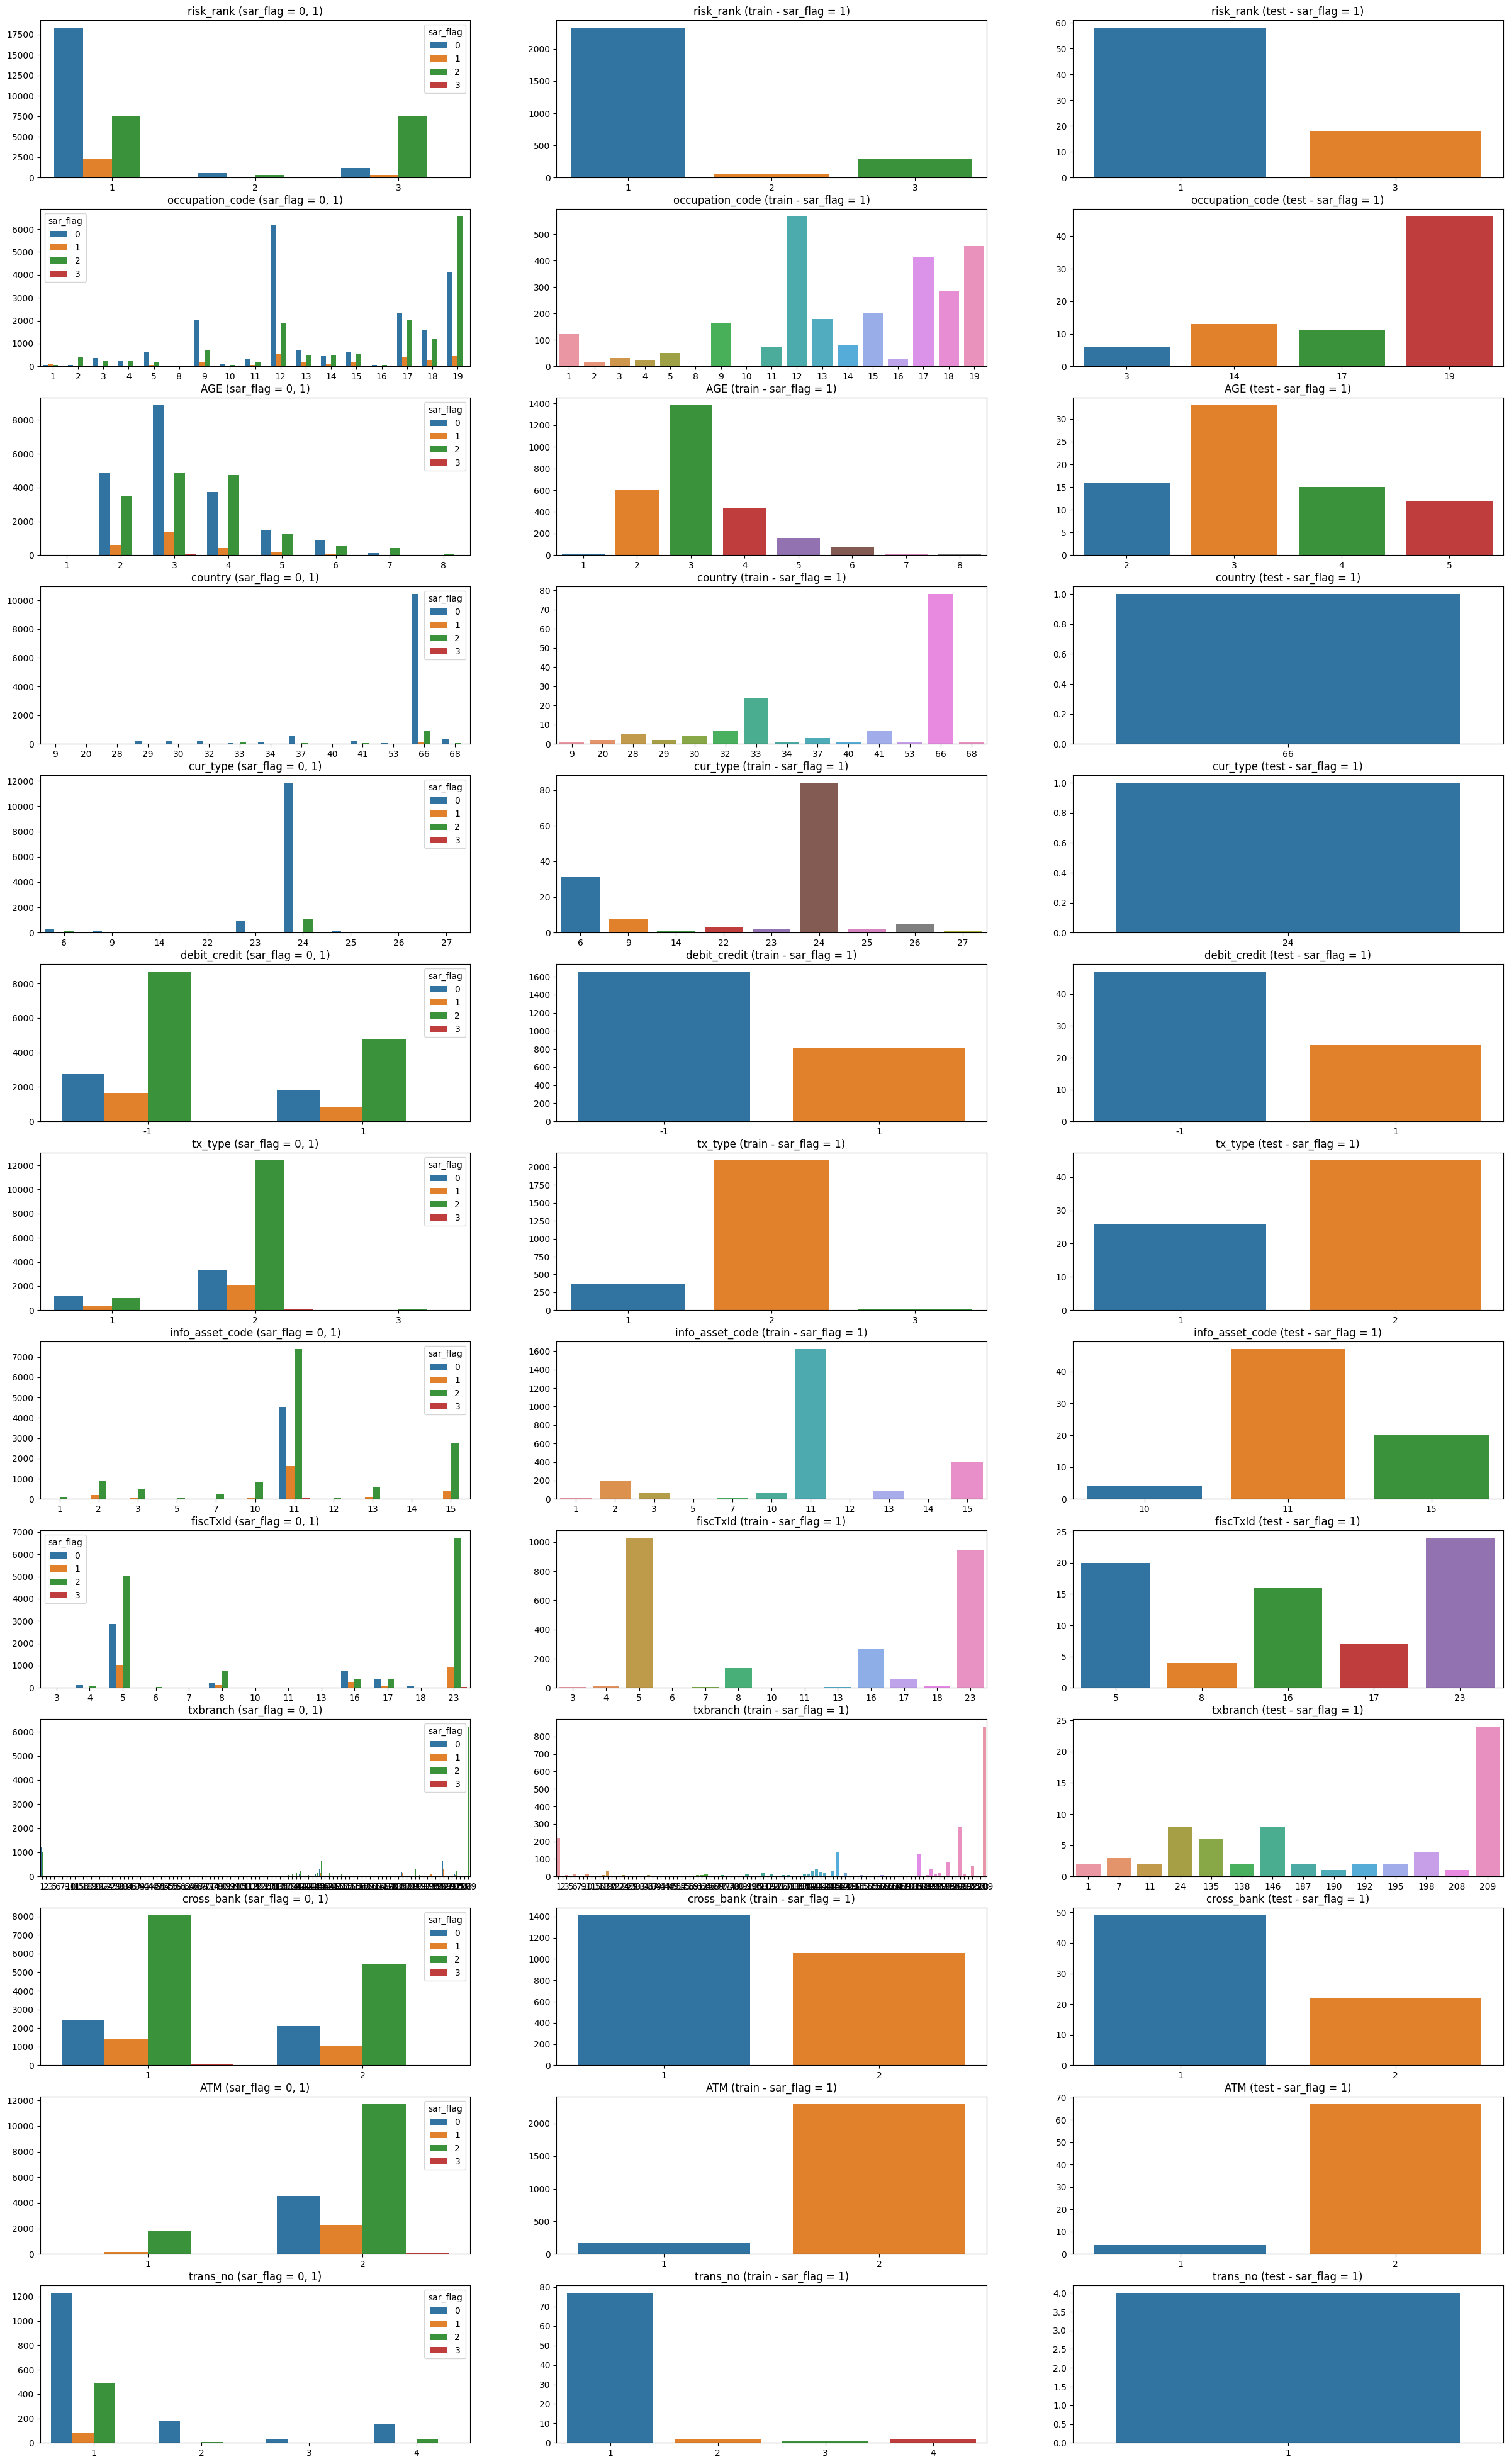

In [53]:
# 各類別變數與y的關係
## 沒出現在sar_falg = 1的類別，以-1取代
feats = cat_feats
k = 0
a, b = 13, 3
fig, ax = plt.subplots(a, b, figsize = (30, 50))
for i in range(a):
    for j in range(1):
        try:
            if feats[k] != "debit_credit":
                data = train2[(train2[feats[k]] > 0)]
            else:
                data = train2[(train2[feats[k]] != 0)]

            sns.countplot(data = data, x = feats[k], hue = target, ax = ax[i, j])
            sns.countplot(data = data.query("(sar_flag == 1)"), x = feats[k], ax = ax[i, j+1])
            sns.countplot(data = data.query("(sar_flag == 3)"), x = feats[k], ax = ax[i, j+2])

            ax[i, j].set(ylabel = None, xlabel = None, title = f"{feats[k]} (sar_flag = 0, 1)")
            ax[i, j + 1].set(ylabel = None, xlabel = None, title = f"{feats[k]} (train - sar_flag = 1)")
            ax[i, j + 2].set(ylabel = None, xlabel = None, title = f"{feats[k]} (test - sar_flag = 1)")
            k += 1
        except:
            continue

# fig.savefig("data/image/cat_feats_replace.png")

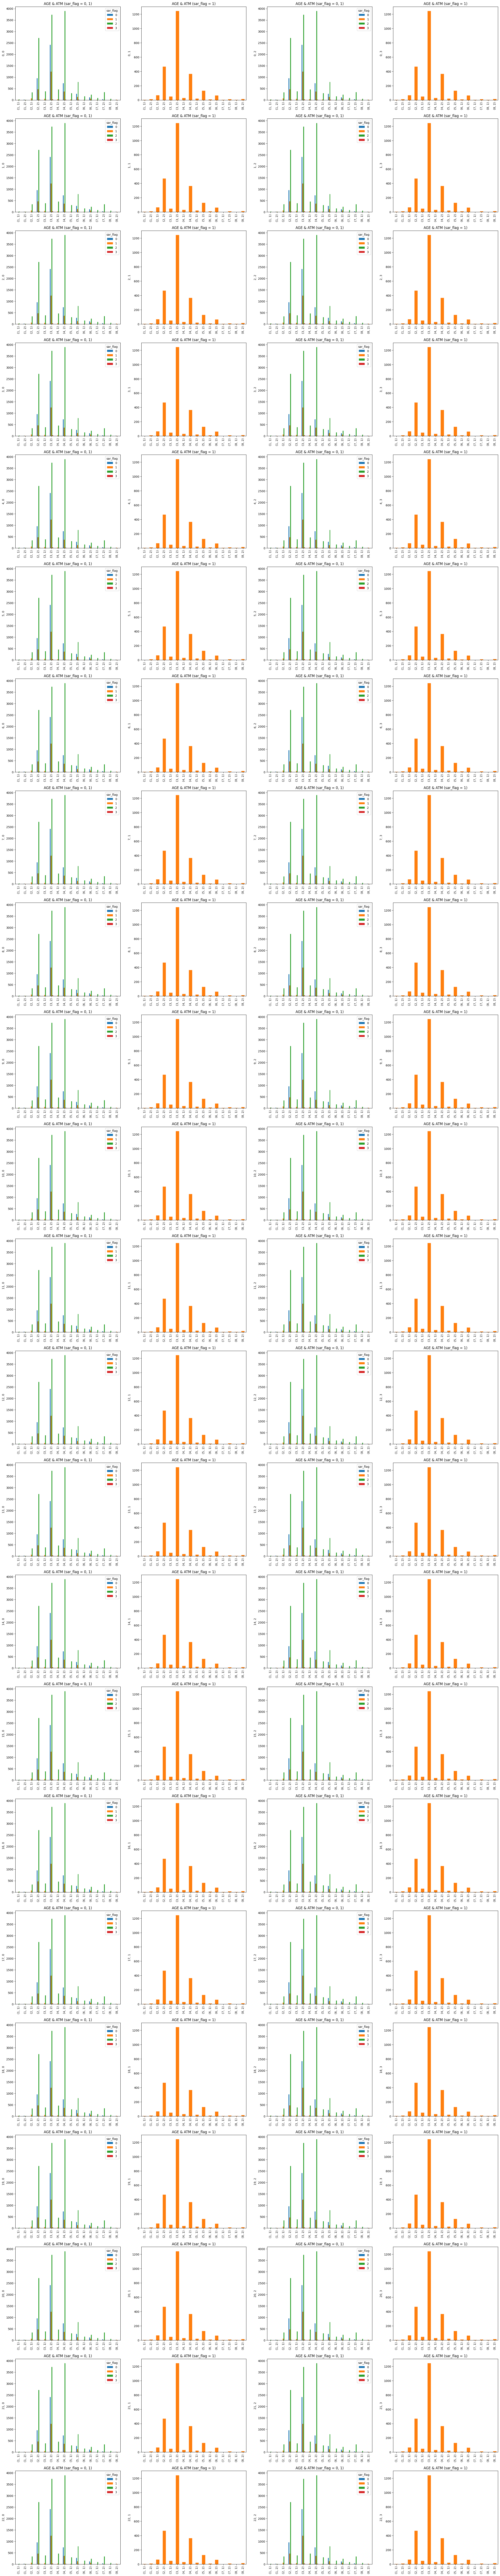

In [54]:
# 兩兩類別變數與y的關係
df_gbs = pd.DataFrame()
feats = pair_cat_feats
k = 0
a, b = 23, 4
fig, ax = plt.subplots(a, b, figsize = (30, 160))
for i in range(a):
    for j in range(0, b, 2):
        try:
            feat = list(feats[k])
            
            train3 = train2.copy()
            train3 = train3[(train3[feat[0]] != 0) & (train3[feat[1]] != 0)]

            df_gb = train3.groupby([feat[0], feat[1], target]).size().unstack()
            df_gb = df_gb.loc[df_gb[1].dropna().index]

            df_gb.plot(kind = "bar", ax = ax[i, j])
            df_gb[1].plot(kind = "bar", ax = ax[i, j+1], color = "#ff7f0e")

            ax[i, j].set(ylabel = f"{i}, {j}", xlabel = None, title = f"{feat[0]} & {feat[1]} (sar_flag = 0, 1)")
            ax[i, j + 1].set(ylabel = f"{i}, {j+1}", xlabel = None, title = f"{feat[0]} & {feat[1]} (sar_flag = 1)")
            
            
            df_gb = df_gb.reset_index()
            col = df_gb.columns
            df_gb.insert(0, "cat1", col[0])
            df_gb.insert(2, "cat2", col[1])
            df_gb.columns = ["cat1", "cat_type1", "cat2", "cat_type2", "count0", "count1"]
            
            df_gb["prop1"] = df_gb["count1"]/df_gb["count1"].sum()
            df_gb["prop1_0"] = df_gb["count1"] / (df_gb["count0"] + df_gb["count1"])

            df_gb["row, col"] = f"{i}, {j}"
            df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

            k += 1
        except:
            continue
        
# fig.savefig("data/image/pair_cat_feats.png")